# 합성 데이터 : CV

## 실습 개요

<br> 1) **실습 목적**    
이번 실습을 통해 합성 이미지 데이터를 직접 만들어 보겠습니다. GANs, VAE, Diffusion 등의 모델을 활용하여 기본 이미지로부터 새로운 합성 이미지를 생성할 수 있습니다.   

 2) **수강 목표**  
 - GANs 모델을 활용해 합성 이미지를 만들 수 있다.
 - VAE 모델을 활용해 합성 이미지를 만들 수 있다.
 - Diffusion 모델을 활용해 합성 이미지를 만들 수 있다.

### 실습 목차

* GANs로 이미지 생성하기
  * DCGANs 네트워크 정의
  * DCGANs 네트워크 학습
  * 학습 결과 확인
  </b></font>
* VAE로 이미지 생성하기
  * VAE 네트워크 정의
  * VAE 네트워크 학습
  * 학습 결과 확인
  </b></font>
* Diffusion으로 이미지 생성하기
  * 파이프라인 불러오기
  * 생성된 이미지 확인
  </b></font>

### 환경 설정
- 패키지 설치 및 임포트

#### ❗ 런타임 유형을 GPU로 바꿔주세요!



In [1]:
# GPU 유형을 확인합니다.
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# diffuser 라이브러리를 설치합니다.
# transformers, scipy, ftfy, acclerate 등의 관련 라이브러리를 설치해줍니다.
# acclerate는 로딩 속도를 조금 더 빠르게 해줍니다.
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

   ---------------------------------------- 0.0/524.9 kB ? eta -:--:--
   ---------------------------------------- 524.9/524.9 kB 5.6 MB/s eta 0:00:00


In [3]:
# matplotlib과 seaborn은 시각화 라이브러리들입니다.
!pip install matplotlib seaborn

In [4]:
# 노트북을 실행한 브라우저에서 바로 이미지를 볼 수 있게 해줍니다.
%matplotlib inline

# 파라미터 관리, 운영 체제, 난수 발생, 경로 지정 관련 라이브러리들입니다.
import argparse
import os
import random
from pathlib import Path

# 오픈 소스 머신 러닝 라이브러리인 pytorch 관련 모듈 및 함수들입니다.
import torch
import torch.nn as nn                    # 신경망 구성을 위한 레이어, 함수 모음
import torch.nn.parallel                 # 병렬처리를 위한 모듈
import torch.nn.functional as F          # torchn.nn의 함수 모음
import torch.optim as optim              # 최적화 알고리즘 패키지
from torch.utils.data import DataLoader  # Dataset을 iterable 객체로 변환해주는 함수
from torch.autograd import Variable      # 자동 미분 관련 패캐지, 클래스

# torchvision은 데이터셋과 모델 아키텍쳐, 이미지 변형등을 모아둔 패키지입니다.
import torchvision
from torchvision import datasets         # 빌트인 데이터셋 및 데이터셋 제작 유틸리티 제공
from torchvision import transforms       # 이미지 변형 관련 라이브러리
import torchvision.utils as vutils       # 시각화 관련 유틸리티 모듈
from torchvision.utils import save_image # 주어진 Tensor를 이미지 파일로 저장시켜주는 모듈

# numpy는 다차원 배열의 처리를 지원하는 라이브러리입니다.
import numpy as np

# 이미지의 시각화를 위한 라이브러리들입니다.
import matplotlib.pyplot as plt           # 파이썬 시각화 라이브러리
import matplotlib.animation as animation  # 라이브 애니메이션을 지원하는 모듈
from IPython.display import HTML          # raw data로부터 디스플레이를 만들어 주는 객체
from IPython.display import Image         # raw data로부터 PNG/JPEG/GIF 이미지 객체를 생성

# 이미지 데이터 관련 인터페이스를 제공하는 라이브러리입니다.
import imageio

# Stable Diffusion 파이프라인은 확산 모델의 허깅페이스 API입니다.
from diffusers import StableDiffusionPipeline

# 재생산성을 위해 random seed를 설정해줍니다.
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # 결과 재생산을 위해 필요한 라인입니다.

c:\Users\aidan\anaconda3\Lib\site-packages\diffusers\dynamic_modules_utils.py:90: SyntaxWarning: invalid escape sequence '\s'
  relative_imports = re.findall("^\s*import\s+\.(\S+)\s*$", content, flags=re.MULTILINE)
c:\Users\aidan\anaconda3\Lib\site-packages\diffusers\dynamic_modules_utils.py:92: SyntaxWarning: invalid escape sequence '\s'
  relative_imports += re.findall("^\s*from\s+\.(\S+)\s+import", content, flags=re.MULTILINE)
c:\Users\aidan\anaconda3\Lib\site-packages\diffusers\dynamic_modules_utils.py:134: SyntaxWarning: invalid escape sequence '\s'
  imports = re.findall("^\s*import\s+(\S+)\s*$", content, flags=re.MULTILINE)
c:\Users\aidan\anaconda3\Lib\site-packages\diffusers\dynamic_modules_utils.py:136: SyntaxWarning: invalid escape sequence '\s'
  imports += re.findall("^\s*from\s+(\S+)\s+import", content, flags=re.MULTILINE)


ImportError: cannot import name 'cached_download' from 'huggingface_hub' (c:\Users\aidan\anaconda3\Lib\site-packages\huggingface_hub\__init__.py)

###  데이터셋 개요 </b>

* 데이터 셋: MNIST 데이터베이스(Modified National Institute of Standards and Technology database)
* 데이터 셋 개요: MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋입니다.    
총 6만 개의 학습 데이터와 1만 개의 테스트 데이터로 이루어져 있으며 [이미지]와 [숫자에 대한 라벨]로 구성됩니다.
* 데이터 셋 저작권: CC BY-SA 3.0
* [MNIST - 위키피디아](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)

In [ ]:
# GPU 수를 지정해줍니다. CPU 모드에서는 0을 사용합니다.
ngpu = 1

# 배치 사이즈를 지정해줍니다.
batch_size = 128

# 학습 이미지의 사이즈를 지정해줍니다. transforms를 사용해 해당 사이즈로 변형해줄 것입니다.
image_size = 64

# 데이터셋의 변형을 정의해줍니다.
# 이미지 사이즈를 줄이고 가운데를 자른 다음 텐서로 변형시켜줄 것입니다. 그리고 정규화시켜줄 것입니다.
# CenterCrop은 크기가 변형된 이미지를 그 크기만큼 잘라 배경 노이즈를 제거해주는 데 자주 사용됩니다.
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5, )),
                           ])

# MNIST dataset을 불러옵니다.
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# dataset으로부터 dataloader를 정의해줍니다.
dataloader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)
# device를 지정해줍니다.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 206735309.96it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21539063.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74967387.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19823651.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### 📚 자료

* [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html) : torchvision에서 지원하는 데이터셋과 유틸리티를 확인할 수 있습니다. 목적에 맞는 데이터셋을 찾아 활용할 수 있습니다. CelebA와 같은 데이터셋은 상업적 이용이 불가하니 확인하고 사용하시길 바랍니다.


## 1. GANs로 합성 이미지 생성하기

```
💡 목차 개요 : DCGAN 네트워크를 정의하고 그를 활용해 합성 이미지를 생성합니다.
```

- 1-1 DCGANs 네트워크 정의
- 1-2 DCGANs 네트워크 학습
- 1-3 학습 결과 확인
</font></b>


### 1-1 DCGANs 네트워크 정의

> DCGANs는 적대적 생성 신경망(GANs)의 일종으로, 생성자(Generator)와 구분자(Discriminator)에 합성곱 신경망(convolution)과 전치 합성곱 신경망(convolution-transpose)을 사용했다는 것이 그 특징입니다.



#### 📝 설명 : GANs
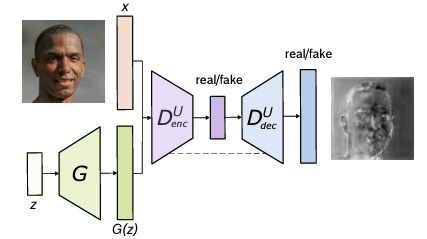

GANs는 생성자와 구분자의 두 가지 모델로 구성됩니다. 생성자의 역할은 실제 이미지와 매우 유사한 이미지를 만드는 것이고 구분자의 역할은 이미지를 보고 실제 이미지인지 아니면 생성자에 의해 만들어진 이미지인지를 알아내는 것입니다.   

모델은 학습을 하는 동안 생성자는 더 진짜 같은 가짜 이미지를 만들어내고 구분자는 그것을 구별할 수 있도록 노력합니다.

그 결과, 생성자는 실제 이미지와 분간이 안될 정도의 완벽한 이미지를 만들어내게 되고 구분자는 생성자에서 나온 이미지를 50%의 확률로 가짜 혹은 진짜로 판별하게 되며 균형 상태에 도달하게 됩니다.

이미지 출처 : [E Schönfeld et al., A U-Net Based Discriminator for Generative Adversarial Networks (2020)](https://arxiv.org/abs/2002.12655)

#### 👨‍💻 코드 : (1-1)


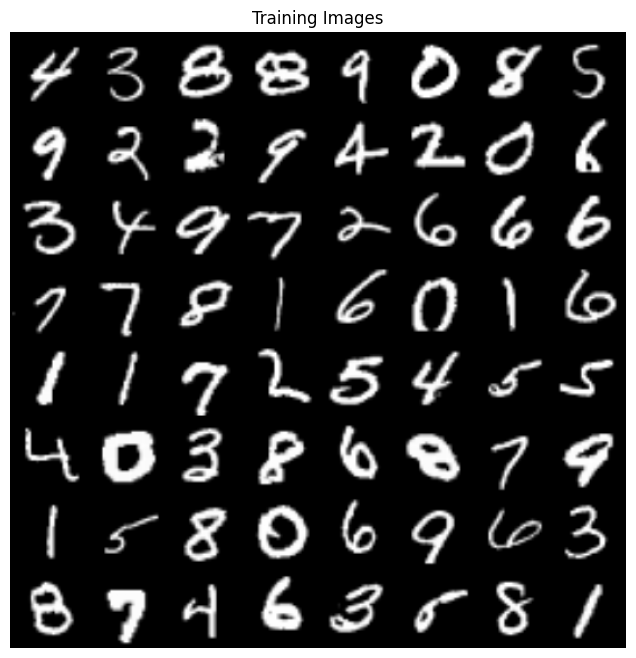

In [ ]:
# 데이터 로더에서 배치를 뽑아 시각화해 보겠습니다.
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**✍ 모델 및 학습에 사용할 파라미터 정의**


In [ ]:
# 학습 이미지의 채널을 설정해줍니다. 칼러 이미지의 경우 3입니다.
# 현재 예제는 흑백 이미지이기 때문에 1로 설정하였습니다.
nc = 1

# 잠재 벡터(latent vector)의 크기를 정해줍니다.
nz = 100

# 생성자의 feature maps 사이즈를 정해줍니다.
ngf = 64

# 구분자의 feature maps 사이즈를 정해줍니다.
ndf = 64

# 학습 에폭 수를 지정해줍니다.
num_epochs = 5

# 옵티마이저의 학습률을 정해줍니다.
lr = 0.0002

# 아담 옵티마이저의 beta1 하이퍼파라미터를 지정해줍니다.
beta1 = 0.5


In [ ]:
# 생성자와 구분자의 가중치 초기화를 위한 함수입니다.
# DCGAN 논문에서는 평균 0, 분산 0.02인 정규분포를 사용해 생성자와 구분자 모두 무작위 초기화를 하는 것이 좋다고 하였습니다.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### 📝 설명 : DCGANs
앞서 언급하였듯 DCGANs은 생성자와 구분자에서 합성곱 신경망(convolution)과 전치 합성곱 신경망(convolution-transpose)을 사용하였습니다.   
합성곱 레이어를 사용하였기 때문에 데이터의 공간적 특징을 캡처할 수 있었고 그 덕에 이미지 생성 작업에 적합합니다.    
DCGANs은 고품질 이미지를 생성하는 데 많이 사용되고 있으며 텍스트, 음성, 비디오 등의 생성에서도 사용되고 있습니다.

아래는 논문의 생성자의 모델 아키텍처입니다. z 입력 벡터의 길이 ``nz``, 생성자를 통과하는 feature map의 크기 ``ngf``, 이미지 채널의 개수 ``nc``로 합성곱 연산이 이뤄지고 있습니다.

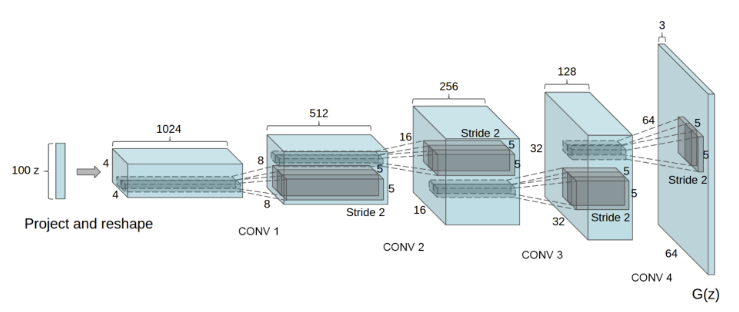

[이미지 출처 : DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


**🏭 생성자**
* 가짜 이미지를 생성하는 생성자 인스턴스를 만들고 가중치를 초기화해줍니다.

#### 📝 설명 : ConvTranspose2d
``torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)``   

ConvTranspose2d는 여러 입력 평면으로 구성된 입력 이미지에 2D 전치 합성곱 연산을 적용합니다.   
* in_channels : 입력 이미지의 채널 수
* out_channels : 합성곱 연산으로 생성된 채널 수
* kernel_size : 합성곱 연산 커널의 크기
* stride : 합성곱 연산의 stride
* padding : ``dilation*(kernel_size-1)-padding`` 제로 패딩이 입력의 각 차원 양쪽에 추가됩니다.
* output_padding : 출력 모양의 각 차원 한쪽에 추가 크기가 추가됩니다.
* groups : 입력 채널에서 출력 채널까지 차단된 연결 수입니다.
* bias : True인 경우 출력에 학습 가능한 바이어스를 추가합니다.
* dilation :  커널 요소 사이의 간격입니다.

참고 사이트 : [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

In [ ]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
            # 마지막 출력 계층에서는 데이터를 tanh 함수에 통과시켜 출력값을 [-1,1] 사이의 범위로 조정합니다.
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 생성자를 만들고 device에 할당해줍니다.
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정할 수 있습니다.
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다.
netG.apply(weights_init)

# 모델 구조를 출력합니다.
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**🚨 구분자**
* 가짜 이미지를 구별하는 구분자 인스턴스를 만들고 가중치를 초기화해줍니다.

#### 📝 설명 : Conv2d
``torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)``   

ConvTranspose2d는 여러 입력 평면으로 구성된 입력 신호에 2D 합성곱 연산을 적용합니다.   
* in_channels : 입력 이미지의 채널 수
* out_channels : 합성곱 연산으로 생성된 채널 수
* kernel_size : 합성곱 연산 커널의 크기
* stride : 합성곱 연산의 stride
* padding :입력의 네 면 모두에 패딩이 추가됩니다.
* padding_mode : 'zeros', 'reflect', 'replicate' or 'circular'
* dilation :  커널 요소 사이의 간격입니다.
* groups : 입력 채널에서 출력 채널까지 차단된 연결 수입니다.
* bias : True인 경우 출력에 학습 가능한 바이어스를 추가합니다.

참고 사이트 : [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [ ]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64`` 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 구분자를 만들고 device에 할당해줍니다.
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정할 수 있습니다.
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다.
netD.apply(weights_init)

# 모델의 구조를 출력합니다.
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


**⏱ 손실 함수와 옵티마이저 정의**
* 손실함수로는 Binary Cross Entropy loss (BCELoss) 를 사용합니다.
* 옵티마이저로는 Adam옵티마이저를 사용합니다.

In [ ]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다.
criterion = nn.BCELoss()

# 시각화에 사용할 잠재 벡터 배치를 만듭니다.
# 생성자의 진행을 확인합니다.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다.
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 1-2 DCGANs 네트워크 학습

> DCGANs의 구분자와 생성자의 학습과정에 대해 살펴보겠습니다.



#### 📝 설명 : 구분자와 생성자의 학습   
**구분자의 학습**   
* 구분자의 목적은 주어진 입력값이 진짜인지 가짜인지 판별하는 것입니다.
* 첫번째 과정에서는 진짜 데이터들로만 이루어진 배치를 만들어 $D$에 통과시키고 손실값을 계산해 역전파 기울기를 축적합니다.
* 두번째 과정에서는 가짜 데이터들로만 이루어진 배치를 만들어 $D$에 통과시키고 손실값을 계산해 역전파 기울기를 축적합니다.
* 마지막으로 진짜 데이터와 가짜 데이터 배치의 기울기를 가지고 옵티마이저 step을 호출합니다.

**생성자의 학습**
* 생성자의 목적은 진짜 같은 가짜 데이터를 만드는 것입니다.
* 가짜 데이터에 대한 구분자의 출력값을 최대화하는 방향으로 학습합니다.
* 먼저, 구분자를 이용해 $G$의 출력값을 판별해주고, 진짜 라벨값을 사용해 $G$의 손실값을 구해줍니다.
* 그렇게 구해진 손실값으로 $G$의 기울기를 계산합니다.
* 마지막으로 옵티마이저 step으로 $G$의 파라미터를 업데이트해줍니다.   

#### 🖥 아래는 G와 D에 대한 통계적 수치들입니다.
*  **Loss_D** - 진짜 배치와 가짜 배치에 대한 손실의 합으로 계산된 구분자의 손실값.  
($log(D(x)) + log(1 - D(G(z)))$)
*  **Loss_G** - 생성자의 손실값.  
$log(D(G(z)))$
*  **D(x)** - 진짜 배치에 대한 구분자의 출력값입니다. 처음에는 1에 가까운 값이다가, G가 학습할수록 0.5값에 수렴하게 됩니다.
*  **D(G(z))** - 가짜 배치에 대한 구분자의 출력값입니다. 처음에는 0에 가까운 값이다가, G가 학습할수록 0.5에 수렴하게 됩니다

#### 👨‍💻 코드 : (1-2)


In [ ]:
# 학습 루프

# 학습 상태를 추적하기 위한 리스트들입니다.
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 각 에폭(epoch)에 대하여
for epoch in range(num_epochs):
    # 데이터로더의 각 배치에 대하여
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 배치로 학습합니다.
        netD.zero_grad()
        # 배치 양식을 불러옵니다.
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 진짜 배치에 대한 손실값을 구합니다.
        errD_real = criterion(output, label)
        # 역전파 과정에서의 기울기를 계산합니다.
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 배치로 학습합니다.
        # 잠재 벡터의 배치를 생성합니다.
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다.
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 가짜 배치를 판별합니다.
        output = netD(fake.detach()).view(-1)
        # 가짜 배치에 대한 D의 손실값을 계산합니다.
        errD_fake = criterion(output, label)
        # 배치에 대한 기울기를 계산하고, 이전 기울기를 더합니다.
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 배치와 진짜 배치에 대한 D의 error를 계산합니다.
        errD = errD_real + errD_fake
        # D를 업데이트합니다.
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다.
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자 손실에서 가짜 라벨은 진짜입니다. (진짜 라벨로 손실을 계산)
        # 방금 D를 업데이트했으므로 D를 통해 가짜 배치의 또 다른 순전파를 수행합니다.
        output = netD(fake).view(-1)
        # 이 출력값을 활용해 G의 손실값을 구합니다.
        errG = criterion(output, label)
        # G의 기울기를 계산합니다.
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.6647	Loss_G: 3.5638	D(x): 0.5276	D(G(z)): 0.5480 / 0.0425
[0/5][50/469]	Loss_D: 0.0114	Loss_G: 10.9376	D(x): 0.9905	D(G(z)): 0.0013 / 0.0000
[0/5][100/469]	Loss_D: 0.3528	Loss_G: 4.3644	D(x): 0.8055	D(G(z)): 0.0330 / 0.0199
[0/5][150/469]	Loss_D: 0.1475	Loss_G: 3.4693	D(x): 0.9146	D(G(z)): 0.0361 / 0.0465
[0/5][200/469]	Loss_D: 0.4221	Loss_G: 9.7090	D(x): 0.9730	D(G(z)): 0.3000 / 0.0001
[0/5][250/469]	Loss_D: 0.1286	Loss_G: 3.7825	D(x): 0.9364	D(G(z)): 0.0535 / 0.0374
[0/5][300/469]	Loss_D: 0.1664	Loss_G: 3.4618	D(x): 0.9145	D(G(z)): 0.0641 / 0.0459
[0/5][350/469]	Loss_D: 0.3450	Loss_G: 0.2599	D(x): 0.7461	D(G(z)): 0.0074 / 0.7940
[0/5][400/469]	Loss_D: 0.2054	Loss_G: 2.5340	D(x): 0.8803	D(G(z)): 0.0640 / 0.1099
[0/5][450/469]	Loss_D: 0.9025	Loss_G: 11.0806	D(x): 0.9583	D(G(z)): 0.4957 / 0.0001
[1/5][0/469]	Loss_D: 0.5052	Loss_G: 3.7132	D(x): 0.7981	D(G(z)): 0.2139 / 0.0332
[1/5][50/469]	Loss_D: 0.2342	Loss_G: 2.7004	D(x): 0.8832	D(G(z))

### 1-3 학습 결과 확인

> 생성자, 구분자의 손실을 시각화하고 생성된 이미지를 확인해보겠습니다.



#### 👨‍💻 코드 : (1-3)


아래는 D와 G의 손실값들을 그래프로 그린 모습입니다

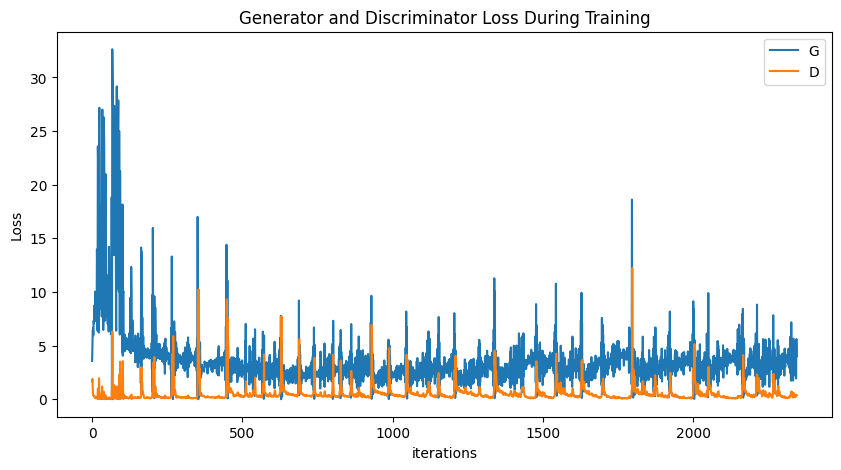

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**🔍 G 학습 과정 시각화**

매 에폭마다 fixed_noise를 이용해 생성자가 만들어낸 이미지를 저장하였습니다. 저장한 이미지들을 애니메이션 형식으로 확인해 봅시다.   
▶ 버튼을 누르면 애니매이션이 실행됩니다

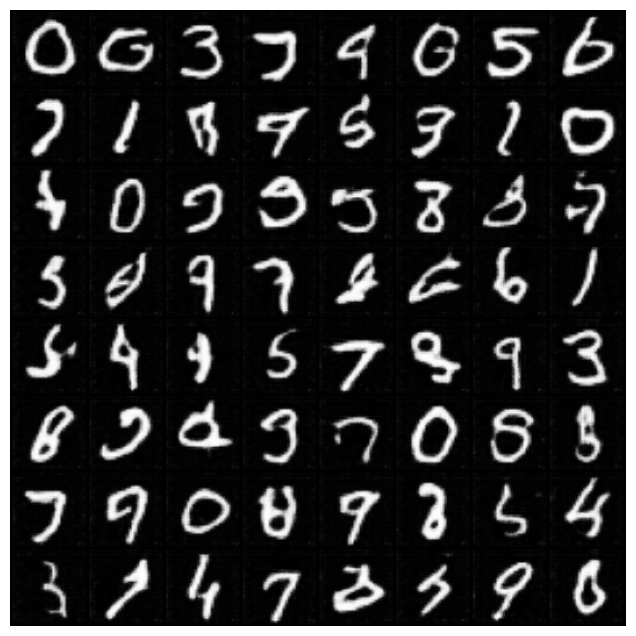

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**😲 진짜 이미지 vs. 가짜 이미지**

진짜 이미지들과 가짜 이미지들을 나란히 두고 비교해 보겠습니다.




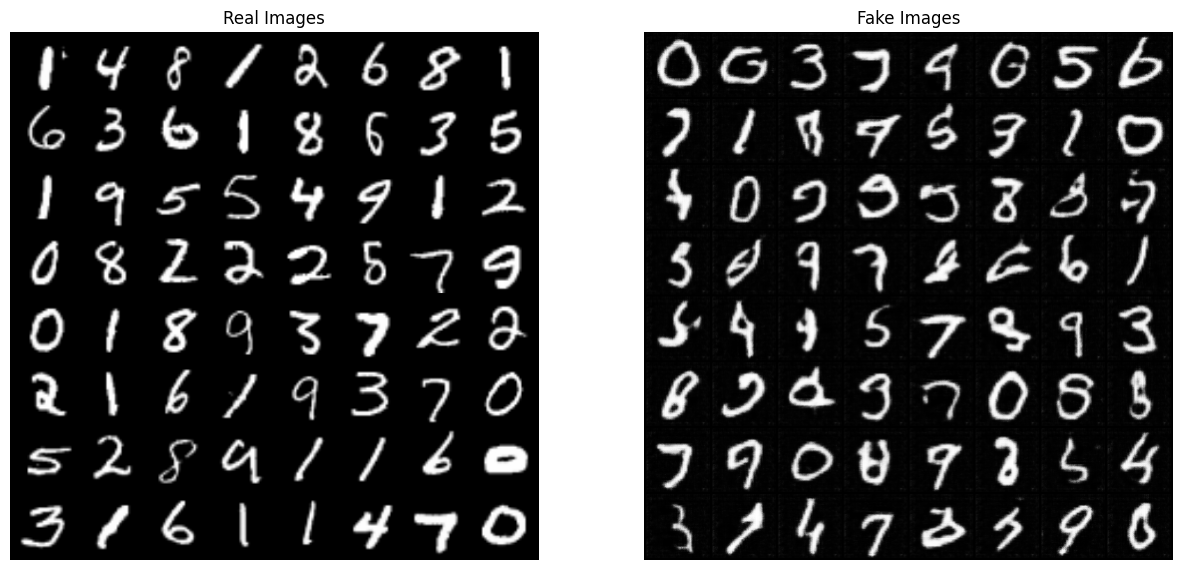

In [ ]:
# dataloader에서 진짜 이미지들의 배치를 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### 📚 함께 보면 좋을 자료

* [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) : GANs을 처음 소개한 논문입니다.
* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) : DCGANs을 처음 소개한 논문입니다.


## 2. VAE로 합성 이미지 생성하기

```
💡 목차 개요 : VAE를 사용하여 합성 이미지를 생성할 수 있다.
```

- 2-1 VAE 네트워크 정의
- 2-2 VAE 네트워크 학습
- 2-3 학습 결과 확인
</font></b>


### 2-1 VAE 네트워크 정의

> VAE(Variational AutoEncoder)는 입력데이터를 저차원 잠재공간에 매핑하는 인코더(encoder)와 잠재공간에서 입력 공간으로 매핑하는 디코더(decoder)로 구성된 확률적 생성 모델입니다.


#### 📝 설명 : VAE 네트워크 구조
* 아래는 VAE의 기본 네트워크 구조입니다. 모델은 입력 데이터 X를 받아 인코더에서 이를 잠재 공간으로 압축합니다. 디코더는 잠재 공간에서 샘플링된 정보를 입력으로 받아 x'을 생성합니다.
* 데이터를 저차원의 잠재공간으로 압축하는 것은 데이터의 복잡성을 줄이고 데이터의 특징을 추출하는 데 도움이 됩니다.
* 데이터에서 의미있는 패턴을 찾아 새롭고 현실적인 샘플을 생성할 수 있게 해줍니다.

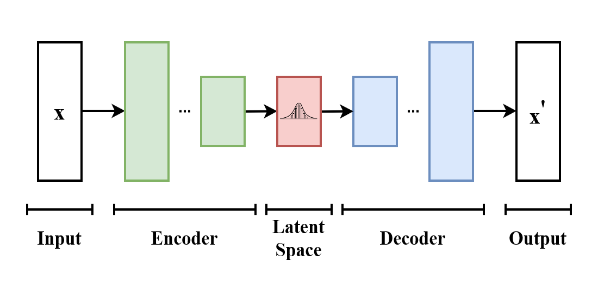

[이미지 출처 : 위키피디아](https://en.wikipedia.org/wiki/Variational_autoencoder)

#### 👨‍💻 코드 : (2-1)


**⛽ 함수정의**

In [ ]:
# 데이터를 Variable로 반환하는 함수입니다.
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [ ]:
# 데이터를 1차원으로 flatten시켜주는 함수입니다.
def flatten(x):
    return to_var(x.view(x.size(0), -1))

In [ ]:
# 이미지 저장을 위한 함수입니다.
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [ ]:
# 데이터를 새로 불러와줍니다. 이전 예제에서 사용한 변형을 여기서는 사용하지 않습니다.
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.use_deterministic_algorithms(False) # True로 사용하기 위해서는 CuBLAS 환경 설정이 필요, 여기서는 False로 진행

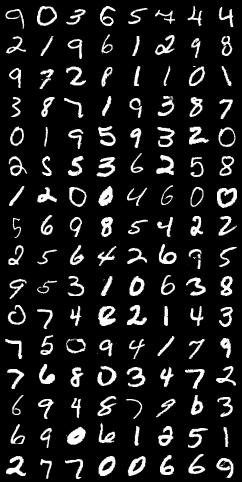

In [ ]:
# 데이터로더에서 배치를 뽑아 이미지를 시각화합니다.
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)

Image('real_image.png')

**⚡ 네트워크 정의**

 #### 📝 설명 : 재매개변수화(Reparameterization)
* 아래는 재매개개변수화에 대한 그림입니다. 무작위성 변수 ${\epsilon}$를 잠재 공간에 주입합니다. 이를 통해 업데이트 과정 중에 확률 변수를 포함하지 않고 기울기를 역전파하는 것이 가능해집니다.  

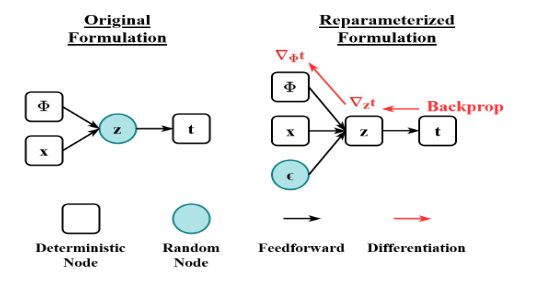

* 재매개변수화의 목적은 샘플링 과정을 미분가능하게 만드는 데 있습니다.
* 일반적인 경사하강법 공식을 사용했을 경우, z를 샘플링할 때 무작위성이 생겨 역전파가 불가능해지고 병목현상이 발생합니다.
* 재매개변수화 트릭은 무작위성을 가지는 변수 ${\epsilon}$를 사용해 z를 근사시키고 역전파를 가능하게 합니다.   

* 다음은 재매개변수화를 반영한 VAE 네트워크 구성에 대한 그림입니다.   

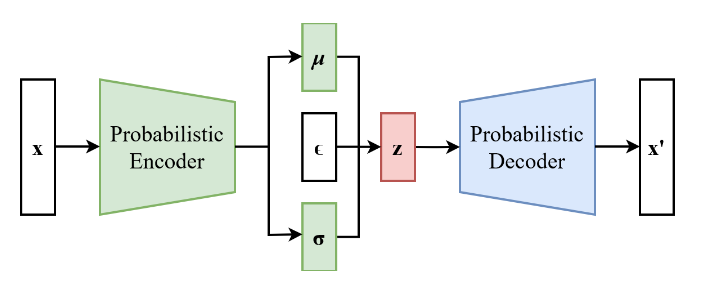   

[이미지 출처 : 위키피디아](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [ ]:
# VAE 모듈을 정의해줍니다.
# torch 모듈을 상속받고 인코더와 디코더를 정의해줍니다.
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    # 재개매변수화 트릭에 대한 함수입니다.
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    # 순전파 함수입니다.
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [ ]:
# vae 인스턴스를 만들고 gpu에 올려줍니다.
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

### 2-2 VAE 네트워크 학습

> VAE 네트워크의 학습 과정에 대해 살펴보겠습니다.

#### 👨‍💻 코드 : (2-2)


**⏱ 손실 함수와 옵티마이저 정의**
* 손실 함수로는 BCE와 KLD(KL Divergence)의 합을 사용합니다.
* 옵티마이저로는 Adam 옵티마이저를 사용합니다.

In [ ]:
# 손실함수를 정의해줍니다. BCE Loss를 사용하였습니다.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # 아래는 VAE 논문 부록 B의 내용입니다.
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [ ]:
# 옵티마이저로 adam을 사용합니다.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [ ]:
# 학습 에폭을 설정해줍니다.
epochs = 10

In [ ]:
# 생성 이미지를 저장하기 위한 디렉토리를 지정해줍니다.
path = './reconstructed'
if not os.path.isdir(path):
  os.mkdir(path)

In [ ]:
# 네트워크를 학습하고 중간 이미지를 저장해줍니다.
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/batch_size))

            recon_x, _, _ = vae(fixed_x)
            save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'./reconstructed/recon_image_{epoch}_{idx}.png')

Epoch[1/10] Loss: 550.306
Epoch[1/10] Loss: 173.960
Epoch[1/10] Loss: 148.865
Epoch[1/10] Loss: 138.957
Epoch[1/10] Loss: 129.712
Epoch[2/10] Loss: 127.555
Epoch[2/10] Loss: 121.592
Epoch[2/10] Loss: 112.713
Epoch[2/10] Loss: 112.853
Epoch[2/10] Loss: 117.735
Epoch[3/10] Loss: 110.865
Epoch[3/10] Loss: 117.679
Epoch[3/10] Loss: 115.218
Epoch[3/10] Loss: 110.767
Epoch[3/10] Loss: 113.397
Epoch[4/10] Loss: 111.060
Epoch[4/10] Loss: 107.618
Epoch[4/10] Loss: 111.142
Epoch[4/10] Loss: 113.331
Epoch[4/10] Loss: 110.775
Epoch[5/10] Loss: 103.028
Epoch[5/10] Loss: 106.519
Epoch[5/10] Loss: 108.729
Epoch[5/10] Loss: 107.448
Epoch[5/10] Loss: 110.583
Epoch[6/10] Loss: 107.618
Epoch[6/10] Loss: 109.130
Epoch[6/10] Loss: 109.889
Epoch[6/10] Loss: 111.298
Epoch[6/10] Loss: 108.774
Epoch[7/10] Loss: 105.774
Epoch[7/10] Loss: 109.567
Epoch[7/10] Loss: 104.752
Epoch[7/10] Loss: 108.144
Epoch[7/10] Loss: 103.663
Epoch[8/10] Loss: 109.373
Epoch[8/10] Loss: 103.631
Epoch[8/10] Loss: 108.948
Epoch[8/10] 

### 2-3 학습 결과 확인

> 이미지 생성 결과를 확인해보겠습니다.


#### 👨‍💻 코드 : (2-3)


아래는 랜덤값을 가지고 샘플이미지를 생성한 결과입니다.

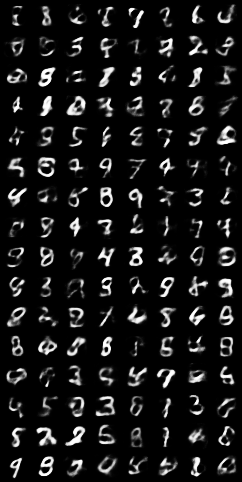

In [ ]:
# 랜덤값을 발생시키고 VAE 디코더에 넣어 새로운 샘플을 생성합니다.
sample = Variable(torch.randn(128, 20)).to(device)
recon_x = vae.decoder(sample)

save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), 'sample_image.png')
Image('sample_image.png')

아래는 학습 중간에 생성된 이미지들을 애니메이션으로 시각화한 것입니다.

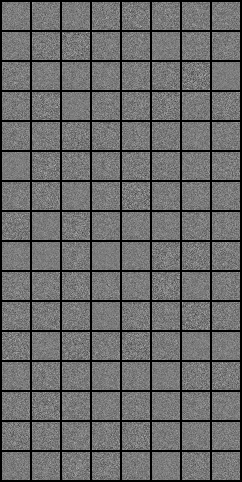

In [ ]:
# reconstructed 경로 아래의 png 파일들을 찾아 리스트로 묶고 시각화하였습니다.
images = []
for file in sorted([file for file in Path('./reconstructed').glob('*.png')]):
    images.append(imageio.imread(file))
imageio.mimsave('recon_image.gif', images)
Image(filename="recon_image.gif")

#### 📚 함께 보면 좋을 자료
* [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) : Variational AutoEncoder를 소개한 논문입니다.


## 3. Diffusion으로 합성 이미지 생성하기

```
💡 목차 개요 : Hugging Face Diffuser 라이브러리로 Stable Diffusion 파이프라인을 불러와 합성 이미지를 간단히 만들 수 있다.
```

- 3-1 파이프라인 불러오기
- 3-2 생성된 이미지 확인
</font></b>


### 3-1 파이프라인 불러오기

> Huggingface에서 제공하는 파이프라인을 활용해 사전 학습된 모델을 간단하게 불러와 사용할 수 있습니다.



#### 📝 설명 : Hugging Face Diffusers
*  Diffusers는 Hugging Face에서 제공하는 확산 모델을 위한 라이브러리입니다. 다양한 파이프라인과 사전학습된 모델들을 제공하고 있으며 튜토리얼과 가이드 등의 자료 또한 참고해 볼 수 있습니다.

참고 사이트 : [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index)

#### 👨‍💻 코드 : (3-1)

In [ ]:
# Stable Diffusion 파이프라인을 활용해 사전학습된 모델을 불러와줍니다.

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


### 3-2 생성된 이미지 확인

> 프롬프트를 입력하여 이미지를 생성하고 그 결과를 확인할 수 있습니다.



#### 👨‍💻 코드 : (3-2)

In [ ]:
# 파이프라인을 gpu에 올려줍니다.
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

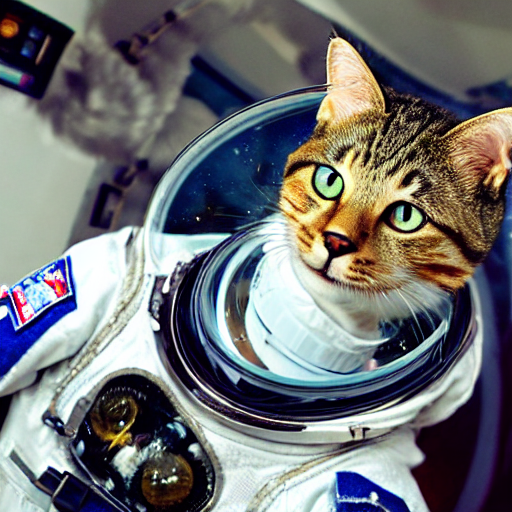

In [ ]:
# 아래 프롬프트에 원하는 이미지의 설명을 입력하고 파이프라인을 통해 생성해줍니다.
prompt = "a photograph of cat astronaut"
image = pipe(prompt).images[0]

# 생성된 이미지를 저장합니다.
image.save(f"cat_astronaut.png")

# 이미지를 바로 확인합니다.
image

#### 📚 함께 보면 좋을 자료
* [Diffusers](https://huggingface.co/docs/diffusers/index) : 허깅페이스 디퓨저 라이브러리 링크입니다.
* [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) : Diffusion probabilistic 모델을 소개한 논문입니다.
* [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456): 확률적 미분 방정식(SDE)를 활용해 Diffusion process를 모델링하는 방법을 소개한 논문입니다.

#Reference

- [DCGAN TUTORIAL](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- [VAE code](https://github.com/sksq96/pytorch-vae/blob/master/vae.ipynb)
- [VAE Wikipedia](https://en.wikipedia.org/wiki/Variational_autoencoder)
- [Stable_diffusion](https://github.com/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)

## Required Package

diffusers==0.11.1   
transformers==4.34.0   
scipy==1.11.3    
ftfy==6.1.1     
accelerate==0.23.0    
matplotlib==3.7.1    
seaborn==0.12.2     

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>